# DSI19 Project 2 - Initial Feature Engineering notebook
---

## Table of Contents

* [1. Quality & Condition Feature Engineering](#chapter1)
    * [1.1 Parameters with quality scale](#section_1_1)
    * [1.2 Overall Quality/Condition](#section_1_2)
* [2. Size Feature Engineering](#chapter2)
* [3. Location Feature Engineering](#chapter3)
    * [3.1 MS Zoning](#section_3_1)
    * [3.2 Neighborhood](#section_3_2)
    * [3.3 Accessibility](#section_3_3)
    * [3.4 Total Location Score](#section_3_4)
* [4. Summary](#chapter4)

In [1]:
# Import modules required
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

%config InLineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Read in data sets
train_df = pd.read_csv('../datasets/clean_train.csv')
test_df = pd.read_csv('../datasets/clean_test.csv')
train_df.drop('Unnamed: 0',axis=1,inplace=True)
test_df.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
display(train_df.head())

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,60,RL,73.385027,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,60,RL,43.000000,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,20,RL,68.000000,7922,Pave,Reg,Lvl,AllPub,Inside,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,60,RL,73.000000,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,50,RL,82.000000,14235,Pave,IR1,Lvl,AllPub,Inside,...,59,0,0,0,0,0,3,2010,WD,138500


## 1. Quality & Condition Feature Engineering <a class="anchor" id="chapter1"></a>
---
### 1.1 Parameters with quality scale <a class="anchor" id="section_1_1"></a>

There are multiple parameters within the data that are rated on the same quality scale. All these parmaters describe the quality/condition of a certain aspect of the property. In order to use these paramaters in our model, we will assign a numeric score of the following.

|Value|Description|Score|
|:-:|:-:|:-:|
|Ex|Excellent|5|
|Gd|Good|4|
|TA|Average/Typical|3|
|Fa|Fair|2|
|Po|Poor|1|

In [4]:
# Compiling list of columns with quality scores
qual_cols = ['Exter Qual', 'Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Garage Cond','Garage Qual']
# Creating dictionary for mapping
qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}

In [5]:
# Change quality values for both train and test data set
for col in qual_cols:
    train_df[col] = train_df[col].map(qual_dict)
    test_df[col] = test_df[col].map(qual_dict)

In [6]:
display(train_df[qual_cols].head())

,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Heating QC,Kitchen Qual,Garage Cond,Garage Qual
0,4,3,3,3,5,4,3,3
1,4,3,4,3,5,4,3,3
2,3,4,3,3,3,4,3,3
3,3,3,4,3,4,3,3,3
4,3,3,2,4,3,3,3,3


### 1.2 Overall Quality/Condition <a class="anchor" id="section_1_2"></a>

There are 2 metrics, 'Overall Qual' and 'Overall Cond' that are measured on a numeric scale. 'Overall Qual' measures the material and finish of the house and 'Overall Cond' gives a score based on the condition of the house.

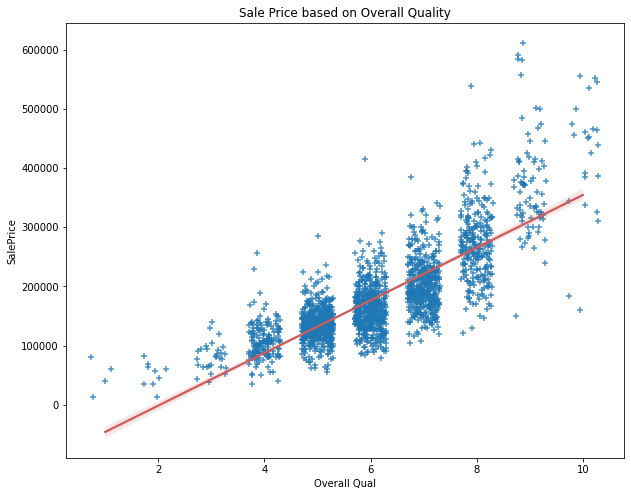

In [7]:
# Plotting to observe between sale price and rating of overall quality of the property
plt.figure(figsize=(10,8))
plt.title("Sale Price based on Overall Quality")
sns.regplot(x = 'Overall Qual', y = 'SalePrice', data = train_df, x_jitter=0.3,marker = "+",line_kws={'color':'indianred'});

When observing the relationship between the overall quality and sale price, we see a positive correlation as expected. The better the materials used and finish of the house, the higher the sale price.

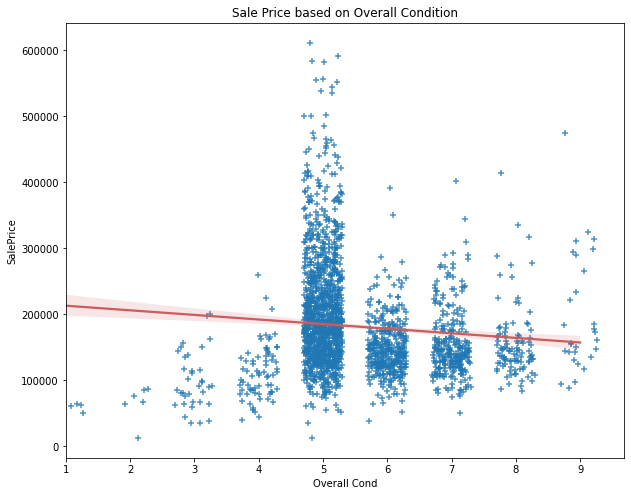

In [8]:
# Plotting to observe between sale price and rating of overall condition of the property
plt.figure(figsize=(10,8))
plt.title("Sale Price based on Overall Condition")
sns.regplot(x = 'Overall Cond', y = 'SalePrice', data = train_df, x_jitter=0.3,marker = "+",line_kws={'color':'indianred'});

Conversely, the relationship between the overall condition of the house and the sale price is not positively correlated. This is because the price of the house is evaluated more on size and location of the house and the condition of the house would affect the price between 2 comparably sized houses in the same location.

## 2. Size Feature Engineering <a class="anchor" id="chapter2"></a>
---
Size of the property is one of the main factors affecting the price of the house. Typically, the larger the house, the more expensive the house is. Size will be evaluated based on 2 main aspect.

Built-in Area (refers to the total area developed) is sum of:
- Total Bsmt SF: Size of basement in sq ft
- Gr Liv Area: Size of all floors in sq ft
- Wood Deck SF: Wood deck in sq ft
- Open Porch SF: Open porch area in sq ft
- Enclosed Porch: Enclosed porch area in sq ft
- Screen Porch: Screen porch area in sq ft
- 3Ssn Porch: 3 Season porch area in sq ft

Land Area (refers to the size of the land the property sits on):
- Lot Area: Lot size in sq ft

In [9]:
# Creating columns for total built-in area
train_df['built_in_SF'] = (train_df['Total Bsmt SF']+
                           train_df['Gr Liv Area']+
                           train_df['Wood Deck SF']+
                           train_df['Open Porch SF']+
                           train_df['Enclosed Porch']+
                           train_df['Screen Porch']+
                           train_df['3Ssn Porch'])
test_df['built_in_SF'] = (test_df['Total Bsmt SF']+
                          test_df['Gr Liv Area']+
                          test_df['Wood Deck SF']+
                          test_df['Open Porch SF']+
                          test_df['Enclosed Porch']+
                          test_df['Screen Porch']+
                          test_df['3Ssn Porch'])

In [10]:
display(train_df[['built_in_SF','Lot Area','Total Bsmt SF','Gr Liv Area','Wood Deck SF','Open Porch SF','Enclosed Porch','Screen Porch','3Ssn Porch']].head())

,built_in_SF,Lot Area,Total Bsmt SF,Gr Liv Area,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,3Ssn Porch
0,2248.0,13517,725.0,1479,0,44,0,0,0
1,3109.0,11492,913.0,2122,0,74,0,0,0
2,2166.0,7922,1057.0,1057,0,52,0,0,0
3,1928.0,9802,384.0,1444,100,0,0,0,0
4,2180.0,14235,676.0,1445,0,59,0,0,0


---
A common metric used to assess property is the price per square feet. Now that there is the total built-in area and land area, the price per square feet based on both land area and built-in area will be created.

In [11]:
# Creating price per sq ft for both built-in area and land area
train_df['built_in_ppsf'] = train_df['SalePrice']/train_df['built_in_SF']
train_df['land_ppsf'] = train_df['SalePrice']/train_df['Lot Area']

## 3. Location Feature Engineering <a class="anchor" id="chapter3"></a>
---
Location of the property is one of the key conisderations during a purchase. Given the parameters, we will assign a location score. 

Parameters that will contribute to Location score will be:
- MS Zoning: Indicates general zone
- Neighborhood: Indicates which specific neighbourhood the property is in
- Condition 1: Accessibility of property
- Condition 2: Accessibility of property

### 3.1 MS Zoning <a class="anchor" id="section_3_1"></a>
---
MS Zoning identified the general zoning classification of the residential property sold. Location is one of the key considerations in the purchase of any residential property. Cities engage in urban planning by zoning the city.

The 'Overall Qual' parameter within the data set describes the overall material and finish of the property. The mean of the Overall Qual grouped by MS Zoning is displayed below.

In [12]:
display(train_df[['Overall Qual','MS Zoning']].groupby('MS Zoning').describe())

Overall Qual                                              
                 count      mean       std  min  25%  50%  75%   max
MS Zoning                                                           
A (agr)            2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
C (all)           19.0  3.842105  0.834210  2.0  3.0  4.0  4.0   5.0
FV               101.0  7.287129  0.898183  5.0  7.0  7.0  8.0  10.0
I (all)            1.0  2.000000       NaN  2.0  2.0  2.0  2.0   2.0
RH                14.0  5.500000  0.854850  4.0  5.0  6.0  6.0   7.0
RL              1598.0  6.207760  1.404667  1.0  5.0  6.0  7.0  10.0
RM               316.0  5.462025  1.203888  2.0  5.0  5.0  6.0  10.0

It is observed that the overall quality follows a certain trend. The various MS Zoning will be assigned a score as follows.

|Value|Zone|Score|
|:-:|:-:|:-:|
|FV|Floating Village Residential|7|
|RL|Residential Low Density|6|
|RM|Residential Medium Density|5|
|RL|Residential Low Density|4|
|C (all)|Commercial|3|
|A (agr)|Agriculture|2|
|I (all)|Industrial|1|

In [13]:
# Create dictionary for values
zoning_dict = {'FV':7, 'RH':6, 'RM':5, 'RL':4, 'C (all)':3, 'A (agr)':2, 'I (all)':1}

# Create MS Zoning score column in train and test data sets
train_df['MS Zoning_score'] = train_df['MS Zoning'].map(zoning_dict)
test_df['MS Zoning_score'] = test_df['MS Zoning'].map(zoning_dict)

### 3.2 Neighborhood <a class="anchor" id="section_3_2"></a>
---
The 'Neighborhood' parameter indicates a more specific location of the property given the general zone. Price per sq ft typically hover around the same for properties within the same neighborhood. 

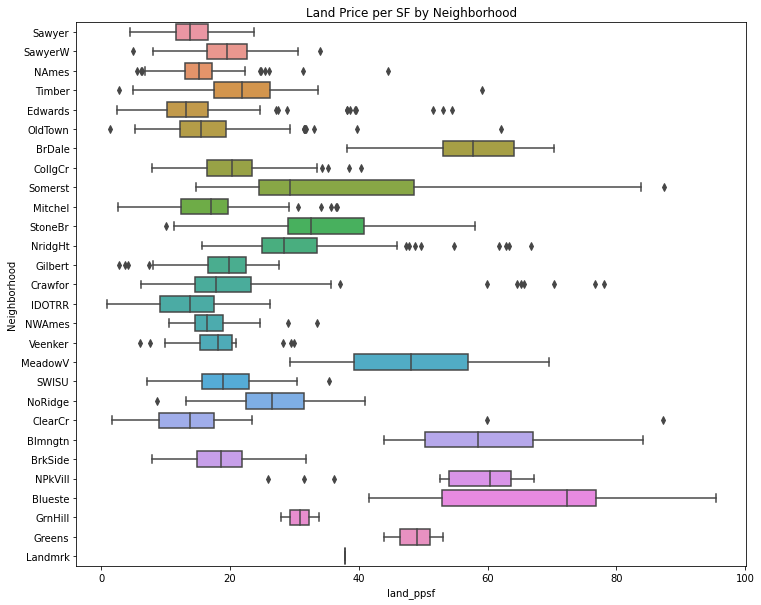

In [14]:
# Plotting price per sq ft for land for the respective neighborhoods
plt.figure(figsize=(12,10))
plt.title("Land Price per SF by Neighborhood")
sns.boxplot(data= train_df,x='land_ppsf',y='Neighborhood');

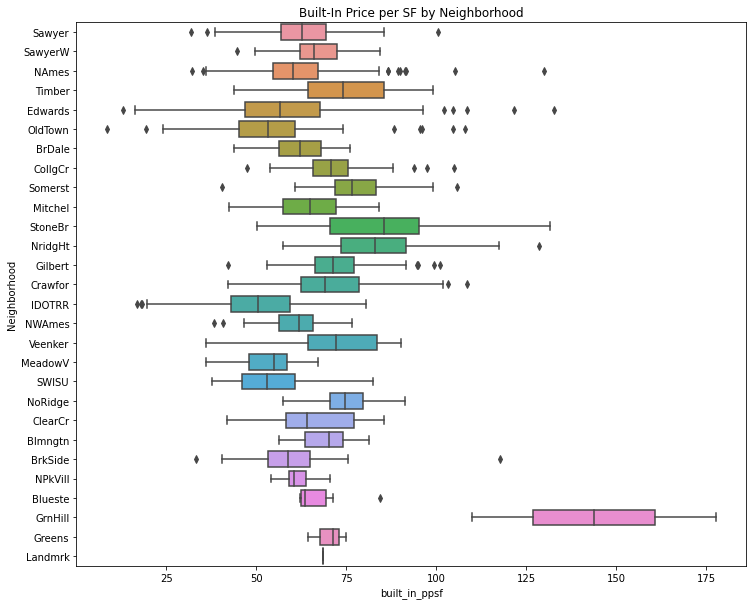

In [15]:
# Plotting price per sq ft by built-in aread for respective neighborhoods
plt.figure(figsize=(12,10))
plt.title("Built-In Price per SF by Neighborhood")
sns.boxplot(data= train_df,x='built_in_ppsf',y='Neighborhood');

The boxplot of built-in price per square feet generally tends to have lower spread compared to land price per square feet. From this, we will assign a desirability of the neighborhood based on the mean on the built-in price per sq ft.

In [16]:
# Creating dataframe with the mean built-in price per sq ft for the respective neighborhoods
neighborhood_df = train_df[['Neighborhood','built_in_ppsf']].groupby('Neighborhood').mean().sort_values(by='built_in_ppsf',ascending= False)
display(neighborhood_df)

,built_in_ppsf
Neighborhood,
GrnHill,143.729853
StoneBr,84.786848
NridgHt,83.215446
Somerst,77.447948
NoRidge,75.193554
Timber,74.580389
Gilbert,72.215463
Veenker,71.534643
CollgCr,70.979208


In [17]:
# Creating criteria for ranking of neighborhoods based on built-in price per sq ft
criteria = [neighborhood_df['built_in_ppsf'].between(50,55), 
            neighborhood_df['built_in_ppsf'].between(55,60), 
            neighborhood_df['built_in_ppsf'].between(60,65),
            neighborhood_df['built_in_ppsf'].between(65,70),
            neighborhood_df['built_in_ppsf'].between(70,75),
            neighborhood_df['built_in_ppsf'].between(75,80),
            neighborhood_df['built_in_ppsf'].between(80,85),
            neighborhood_df['built_in_ppsf'].between(85,90),
            neighborhood_df['built_in_ppsf'].between(90,95),
            neighborhood_df['built_in_ppsf'].between(95,100),
            neighborhood_df['built_in_ppsf'].between(100,200)
           ]
values = list(range(1,12))

In [18]:
# Assigning score to neighborhood based on criteria
neighborhood_df['neigh_score'] = np.select(criteria, values, 0)

In [19]:
# Creating new column for neighborhood score
train_df['neighborhood_score'] = train_df['Neighborhood'].map(neighborhood_df.to_dict()['neigh_score'])
test_df['neighborhood_score'] = test_df['Neighborhood'].map(neighborhood_df.to_dict()['neigh_score'])

In [21]:
display(train_df[['Neighborhood','neighborhood_score']].head())

,Neighborhood,neighborhood_score
0,Sawyer,3
1,SawyerW,4
2,NAmes,3
3,Timber,5
4,SawyerW,4


In [22]:
train_df[['Neighborhood','neighborhood_score']].drop_duplicates().sort_values(by='neighborhood_score',ascending=False)

,Neighborhood,neighborhood_score
463,GrnHill,11
22,NridgHt,7
21,StoneBr,7
13,Somerst,6
60,NoRidge,6
27,Crawfor,5
23,Gilbert,5
32,Veenker,5
11,CollgCr,5
3,Timber,5


### 3.3 Conditions <a class="anchor" id="section_3_3"></a>
---
The final aspect of the location score will be based on nearby attributes, defined by 'Condition 1' and 'Condition 2'. These attributes can affect the value of a house positively or negatively, depending on what attribute it is.

|Value|Description|
|:-:|:-:|
|Artery|Adjacent to arterial street|
|Feedr|Adjacent to feeder street|
|Norm|Normal|
|RRNn|Within 200' of North-South Railroad|
|RRAn|Adjacent to North-South Railroad|
|PosN|Near positive off-site feature--park, greenbelt, etc.|
|PosA|Adjacent to postive off-site feature
|RRNe|Within 200' of East-West Railroad|
|RRAe|Adjacent to East-West Railroad|

In [22]:
# Observing the mean sale prices of properties based on attributes present in Condition 1
display(train_df[['SalePrice','Condition 1']].groupby('Condition 1').mean())

,SalePrice
Condition 1,
Artery,128765.000000
Feedr,143223.605505
Norm,185007.310130
PosA,254733.333333
PosN,254794.296296
RRAe,139685.714286
RRAn,172604.777778
RRNe,129616.666667
RRNn,198208.333333


It is observed that positive attribute 'PosN' and 'PosA' which indicate closeness to a positive off-site feature have much higher mean sale prices than other attributes.  

Conversely, attributes such as 'Artery' and 'Feedr' have much lower mean sale prices due to the closeness of the property to high noise/traffic areas.  

Based on this, a score of 1 will be assigned for positive attributes, -1 for negative attributes, and 0 for Normal.

---


In [23]:
# Creating dictionary for mapping of condition values
access_dict = {'Artery':-1,
               'Feedr':-1,
               'RRAe':-1,
               'RRAn':-1,
               'RRNe':-1,
               'RRNn':-1,
               'Norm':0,
               'PosA':1,
               'PosN':1}

In [24]:
# Creating access column for training data set
train_df['cond1'] = train_df['Condition 1'].map(access_dict)
train_df['cond2'] = train_df['Condition 2'].map(access_dict)
train_df['access'] = train_df['cond1'] + train_df['cond2']
train_df.drop(['cond1','cond2'],axis=1,inplace=True)

# Creating access column for testing data set
test_df['cond1'] = test_df['Condition 1'].map(access_dict)
test_df['cond2'] = test_df['Condition 2'].map(access_dict)
test_df['access'] = test_df['cond1'] + test_df['cond2']
test_df.drop(['cond1','cond2'],axis=1,inplace=True)

In [25]:
display(train_df[['Condition 1','Condition 2','access']].head())

,Condition 1,Condition 2,access
0,RRAe,Norm,-1
1,Norm,Norm,0
2,Norm,Norm,0
3,Norm,Norm,0
4,Norm,Norm,0


### 3.4 Total Location Score <a class="anchor" id="section_3_4"></a>
---
Based on the 3 aspects above, a combined location metric will be determined based on the following.

|Parameter|Description|Score Range|
|:-:|:-:|:-:|
|MS Zoning_score|Defines ranking based on zone in which property is located|1 to 7|
|neighborhood_score|Score based on neighborhood in which property is located|1 to 11|
|access|Accessibility of the property|-2 to 2|
|location_score|Score of location based on the sum of the 3 scores above|0 to 20|



In [26]:
# Creating columns with total location score
train_df['location_score'] = train_df['MS Zoning_score']+train_df['neighborhood_score']+train_df['access']
test_df['location_score'] = test_df['MS Zoning_score']+test_df['neighborhood_score']+test_df['access']

## 4. Summary <a class="anchor" id="chapter4"></a>
---
In conclusion the price of the house if affected by 4 main components.
- Overall quality
- Size
- Location
- Additional feature/amenities

Given the parameters in the data sets, some initial feature engineering has been done to allocate scores based on overall quality/condition, size, and location. Following which, Exploratory Data Analysis (EDA) will be done to further look at the relationships of categorical features creating additional features to use in the model.

In [27]:
# Export training and testing data sets
train_df.to_csv("../datasets/train_ife.csv")
test_df.to_csv("../datasets/test_ife.csv")